In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from PIL import Image, ImageDraw

In [2]:
def set_rand_seed(num):
    '''
    Creates random seed so that randomness is repeatable. Initialized first to set all randomness
    '''
    np.random.seed(num)
    
def set_k():
    """
    Uses random seed to randomly set k - changes size of the speckles
    """
    return(np.random.randint(5,100))

def make_mesh(window_size):
    """
    Creates 2D meshgrid for calculating all the functions.
    """
    x = np.arange(window_size)
    y = np.arange(window_size)
    xx, yy = np.meshgrid(x,y)
    return xx,yy

def object_shape(x, y, x_center, y_center, sigma):
    """
    Defines the shape of the average intensity, can be changed for any other form.
    """
    return np.exp(-((x-x_center)**2 + (y-y_center)**2)/2/sigma)
           
def create_object(window_size = 1024, sigma = 5e4):
    """
    Calculates the average intensity on the defined mesh (i.e. on the CDD detector).
    """
    xx, yy = make_mesh(window_size)
    z = object_shape(xx, yy, 350,350, sigma)
    return z

def circle(r):
    return r<1

def bandpass(p,q,r0, n):
    """
    Defines the functional form of the lens. Lens is needed to make a point source.
    """
    return circle(np.sqrt((p-n/2)**2+(q-n/2)**2)/r0)

def make_bandpass(window_size, r0):
    """
    Calculates the lens band pass form on the defined mesh grid.
    """
    xx, yy = make_mesh(window_size)
    band_pass = bandpass(xx, yy, r0, window_size)
    return band_pass

In [16]:
def make_speckles(n, r0):
    """
    Creates speckles
    """
    # random phasors
    rand_field = np.random.rand(n,n) * 1j
    rand_field = np.exp(2*np.pi*rand_field)

    # object intensity in the absence of the speckle        
    object_intensity = create_object(window_size = n)

    # multiply the amplitude distribution by random phasors
    scattered_field = np.sqrt(object_intensity)*rand_field

    # circular function of the lens
    band_pass = make_bandpass(n, r0)

    # field transmitted by the lens
    pupil_field = band_pass*np.fft.fft2(scattered_field)


    image_field = np.fft.ifft2(pupil_field)
    image_intensity = np.abs(image_field)**2
    
    return(image_intensity)


def make_beam_streaks(window_size=1024):
    """
    Creates a random number of triangles to simulate beam streaks. Coordinates are randomly generated around the window.
    Returns: np.array. For masking purposes, value is set to 1
    """
    
    blank = Image.new('L', (window_size,window_size),0)
    #Create random number of beam streaks between 1 and 3
    num_beam_streaks = np.random.randint(1,3)
    
    for i in range(num_beam_streaks):
        #Generating three random vertices
        rand_points = window_size * (np.random.rand(2,2))
        points = np.append(rand_points, [[window_size*np.random.random_sample(), np.sqrt(rand_points[0,1]**2 + rand_points[1,1]**2)]], axis=0)
        
        #Changing format of data points. Yes, there is likely an easier method to do this rather than hardcoding
        a = [(points[0,0],points[0,1]), (points[1,0],points[1,1]), (points[2,0],points[2,1])]
        ImageDraw.Draw(blank).polygon(a, outline=1, fill = 1)
    
    return(np.asarray(blank))

def make_beam_stop(n=1024):
    """
    Creates coordinates and image for beam stop
    Returns: Beam stop as array. For masking purposes, value is set to 2
    """
    rect_coord = [(1/8*n, 1/8*n), (1/8*n, 1/4*n), (1/4*n, 1/4*n), (1/4*n, 1/8*n)]
    r = Image.new('L', (n,n), 0)
    ImageDraw.Draw(r).polygon(rect_coord, outline=2, fill=2)

    return(np.asarray(r))

def add_noise(window_size):
    """
    Adds random noise to image.
    """
    random_array = np.random.rand(window_size,window_size)
    return(random_array)


def save(sample,i):
    """
    Saves file in sim_data folder with iterating number to correspond to number of samples desired
    """
    np.save(f'sim_data/sim {i}', sample)
    i+=1
    
def create_a_sample(rand_seed_num, n=1024):
    """
    Does everything necessary to create both a full sample along with masks. 
    Reutrns: Dictionary with imput and target to be saved.
    """
    set_rand_seed(rand_seed_num)
    
    k = set_k()
    r0 = n/k

    image_intensity = make_speckles(n, r0) + add_noise(n)
    plt.imshow(image_intensity)#, vmin = 0, vmax = 0.5*image_intensity.max())
    plt.figure()
    size = image_intensity.shape
    mask = np.zeros(size)
    Polygon = make_beam_streaks(n)
    beam_stop = make_beam_stop(n)
    new_image = Polygon + image_intensity + beam_stop
    mask = Polygon + mask + beam_stop
    plt.imshow(new_image)#, vmin = 0, vmax = 0.5*image_intensity.max())
    
    return {'input':new_image, 'target': mask}

color bar
plots of intensity and pixels
private github repo

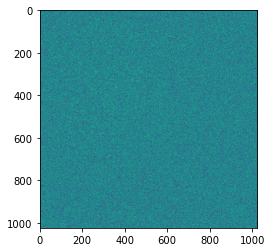

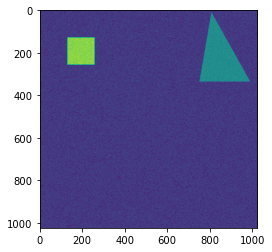

In [21]:
'''MAIN'''
i = 0
# num_samples = 70
# for j in range num_samples:
#     x = create_a_sample(j, 1024)
#     save(x,i)
x=create_a_sample(10, 1024)
#save(x, i)
